# Burgers' Equation with Physics-Informed Neural Networks

## Learning Objectives

In this notebook, you will:
1. Understand the physics of **Burgers' equation** and why it's an important benchmark for PINNs
2. Learn how to encode a **partial differential equation (PDE)** into a physics-informed loss function
3. Implement a PINN for a **2D problem** (time + space)
4. Understand the challenges of solving **shock-like** problems with neural networks
5. Compare PINN performance across different **viscosity regimes**
6. Validate PINN solutions against **finite-difference reference** solvers

## What is Burgers' Equation?

### Physical Context

**Burgers' equation** is a fundamental partial differential equation that appears across fluid mechanics, materials science, and applied mathematics. It serves as a **simplified model of the Navier-Stokes equations**—the foundational equations governing fluid flow. 

Specifically, Burgers' equation captures the essential nonlinear interactions in fluid dynamics while remaining simple enough to study analytically and numerically:
- The **advection term** $u u_x$ models how fluid particles carry momentum (nonlinear steepening)
- The **diffusion term** $\nu u_{xx}$ models viscous dissipation and smoothing

### Why Study Burgers' Equation?

1. **Simplified Navier-Stokes**: Burgers' equation is a 1D, time-dependent nonlinear PDE that exhibits many of the same mathematical challenges as the full Navier-Stokes equations (shocks, boundary layers, turbulence-like behavior) but is much easier to solve.

2. **Rich Phenomenology**:
   - **Smooth diffusion-dominated regime** ($\nu$ large): Solutions remain smooth and easy to approximate
   - **Shock formation** ($\nu$ small): Solutions develop sharp, thin layers called shocks—a key challenge in fluid dynamics
   - The balance between nonlinearity and diffusion creates a **realistic testbed** for numerical and AI methods

3. **Benchmark for Methods**: Because Burgers' equation has exact analytical solutions (via the Cole-Hopf transformation), it's the perfect **benchmark for testing new numerical schemes and machine learning approaches**—including PINNs.

### Applications

Burgers' equation appears naturally in:
- **Turbulence modeling**: Energy cascades and shock formation
- **Traffic flow**: Modeling congestion waves on highways
- **Nonlinear acoustics**: Sound wave propagation in media
- **Shallow water equations**: Approximations to fluid flow in thin layers
- **Materials science**: Dynamics of defects and interfaces

### Why PINNs for Burgers?

Burgers' equation is an **excellent test case for PINNs** because:
- It's **nonlinear** (challenging for neural networks)
- It exhibits **shocks** (exposes PINN limitations)
- Exact solutions exist (allows rigorous validation)
- Physics is **well-understood** (good for teaching)
- Solutions range from **smooth to sharp** (tests different regimes)

## Problem Statement

We aim to solve the **Burgers' equation** using **Physics-Informed Neural Networks (PINNs)**.

The **Burgers' equation** is expressed as:

\begin{equation}
u_t + u u_x = \nu u_{xx}
\end{equation}

where:
- $u(t, x)$ is the unknown function,
- $u_t$ represents the temporal derivative,
- $u_x$ is the spatial derivative,
- $u_{xx}$ is the second spatial derivative,
- $\nu$ is the viscosity term (a positive constant).

The initial and boundary conditions are:

- **Initial Condition**:
\begin{equation}
u(0, x) = -\sin(\pi x), \quad x \in [-1, 1]
\end{equation}

- **Boundary Conditions**:
\begin{equation}
u(t, -1) = u(t, 1) = 0, \quad t \in [0, 1]
\end{equation}

The goal is to approximate $u(t, x)$ using a PINN over the domain $t \in [0, 1], x \in [-1, 1]$.

## Physics intuition (key points for teaching)

Burgers' equation combines two competing physical effects:

> **Nonlinear steepening (advection)** vs **smoothing (viscosity/diffusion)**

### 1) Advection / nonlinear steepening
The term $u\,u_x$ means the field transports itself: regions with larger $u$ move faster. This causes **wave profiles to steepen** (fronts sharpen).

### 2) Viscosity / diffusion
The term $\nu u_{xx}$ smooths gradients. Larger $\nu$ makes solutions more diffuse and easy to approximate; smaller $\nu$ allows very sharp internal layers.

### 3) "Shock" vs "shock-like" behavior
- If $\nu=0$ (inviscid Burgers), characteristics can cross and a true **discontinuity (shock)** forms in finite time.
- If $\nu>0$ (viscous Burgers), discontinuities are replaced by a **very thin smooth transition layer** (often still called a "shock" informally). The layer thickness shrinks as $\nu\downarrow 0$.

### 4) When should we expect shock formation (inviscid estimate)
For $u(0,x)=-\sin(\pi x)$,
\begin{equation}
u_x(0,x)=-\pi\cos(\pi x),\quad \min u_x(0,x)=-\pi.
\end{equation}
A standard inviscid estimate for the first shock time is
\begin{equation}
t_* = -\frac{1}{\min u_x(0,x)} = \frac{1}{\pi}\approx 0.318.
\end{equation}
So for small $\nu$, you should see strong steepening around $t\sim 0.3$.

### 5) How to *see* a shock in plots
A shock-like feature is easiest to detect by plotting the gradient:
- Plot $u(t,x)$ slices vs $x$ at several times (look for a rapidly-changing front).
- Plot $|u_x(t,x)|$ as a heatmap; a shock shows up as a **narrow ridge of large gradient** that becomes thinner as $\nu$ decreases.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# Ensure plots directory exists
os.makedirs("../plots", exist_ok=True)

Computed FD reference for nu = 0.003 | saved times = [0.0, 0.2, 0.32, 0.5, 1.0]


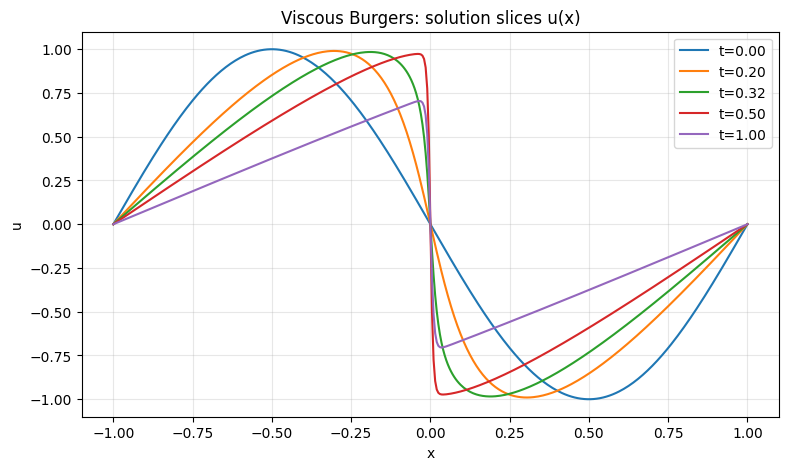

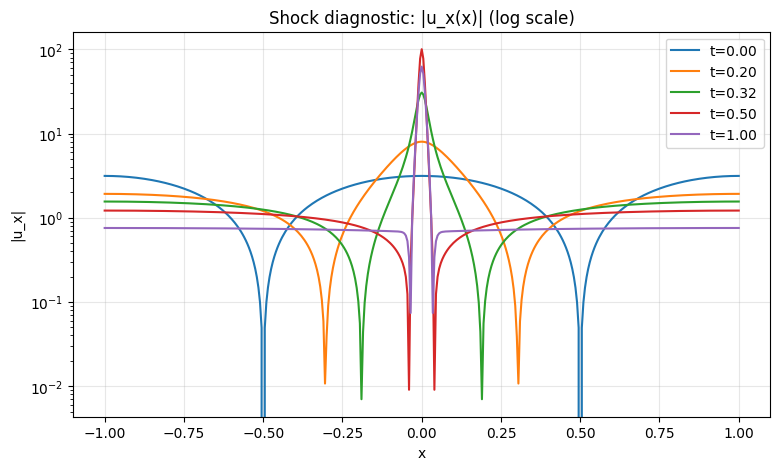

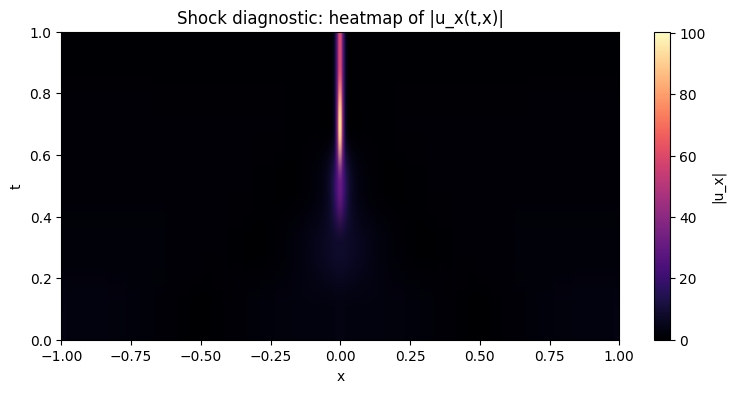

In [2]:
# --- Quick reference solver to visualize shock-like steepening (no training required) ---
# This finite-difference solver gives a "ground truth-ish" solution that clearly shows shock-like layers for small nu.


def burgers_fd_solution(nu=0.003, nx=401, T=1.0, cfl=0.25, save_times=(0.0, 0.2, 0.32, 0.5, 1.0)):
    """
    Solve viscous Burgers on x in [-1,1] with Dirichlet BC u(t,-1)=u(t,1)=0 and IC u(0,x)=-sin(pi x).
    Uses proper upwind advection (based on local velocity sign) + explicit diffusion.
    """
    x = np.linspace(-1.0, 1.0, nx)
    dx = x[1] - x[0]
    u = -np.sin(np.pi * x)
    u[0] = 0.0
    u[-1] = 0.0

    # Collect snapshots at specified times
    save_times = sorted(set(float(t) for t in save_times))
    snaps = {}
    current_t = 0.0

    while current_t < T:
        # Save snapshot if we're at a save time
        for t_save in save_times:
            if t_save not in snaps and current_t >= t_save - 1e-10:
                snaps[t_save] = u.copy()

        # Adaptive dt for stability: CFL for advection + diffusion constraint
        umax = max(1e-8, float(np.max(np.abs(u))))
        dt_adv = cfl * dx / umax
        dt_diff = cfl * dx * dx / (2.0 * max(nu, 1e-12))
        dt = min(dt_adv, dt_diff, T - current_t)

        if dt < 1e-14:
            break

        un = u.copy()

        # Proper upwind: use backward difference where u>0, forward where u<0
        ux_backward = (un[1:-1] - un[:-2]) / dx  # for u > 0
        ux_forward = (un[2:] - un[1:-1]) / dx  # for u < 0
        u_mid = un[1:-1]
        ux = np.where(u_mid >= 0, ux_backward, ux_forward)
        adv = u_mid * ux

        diff = (un[2:] - 2 * un[1:-1] + un[:-2]) / (dx * dx)
        u[1:-1] = un[1:-1] - dt * adv + nu * dt * diff

        # Dirichlet BC
        u[0] = 0.0
        u[-1] = 0.0
        current_t += dt

    # Final snapshot at T
    if T not in snaps:
        snaps[T] = u.copy()

    return x, snaps


def plot_shock_diagnostics(x, snaps):
    # 1) Solution slices
    plt.figure(figsize=(9, 5))
    for t in sorted(snaps.keys()):
        plt.plot(x, snaps[t], label=f"t={t:.2f}")
    plt.title("Viscous Burgers: solution slices u(x)")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 2) Gradient magnitude |u_x| slices (shock detection)
    plt.figure(figsize=(9, 5))
    dx = x[1] - x[0]
    for t in sorted(snaps.keys()):
        ux = np.gradient(snaps[t], dx)
        plt.plot(x, np.abs(ux), label=f"t={t:.2f}")
    plt.yscale("log")
    plt.title("Shock diagnostic: |u_x(x)| (log scale)")
    plt.xlabel("x")
    plt.ylabel("|u_x|")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3) Space–time heatmap of |u_x| (ridge = shock-like layer)
    times = sorted(snaps.keys())
    U = np.stack([snaps[t] for t in times], axis=0)  # (ntimes, nx)
    dx = x[1] - x[0]
    Ux = np.gradient(U, dx, axis=1)

    plt.figure(figsize=(9, 4))
    plt.imshow(
        np.abs(Ux),
        aspect="auto",
        origin="lower",
        extent=[x.min(), x.max(), times[0], times[-1]],
        cmap="magma",
    )
    plt.colorbar(label="|u_x|")
    plt.title("Shock diagnostic: heatmap of |u_x(t,x)|")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()


# Try a shock-like regime (smaller nu => thinner layer)
nu_demo = 0.003
x_fd, snaps_fd = burgers_fd_solution(nu=nu_demo, nx=401, T=1.0, save_times=(0.0, 0.2, 0.32, 0.5, 1.0))
print("Computed FD reference for nu =", nu_demo, "| saved times =", sorted(snaps_fd.keys()))
plot_shock_diagnostics(x_fd, snaps_fd)

## Neural Network Architecture
PINNs use a neural network to represent the solution $u(t, x)$. The network takes the inputs $t$ and $x$ and outputs $u(t, x)$. Here's the structure:
- **Input layer:** 2 features ($t$ and $x$)
- **Hidden layers:** 4 fully connected layers with 64 neurons each
- **Activation function:** `tanh` for all hidden layers (smooth, works well with autograd)
- **Output layer:** A single scalar representing $u(t, x)$

**Why tanh?** PINNs require computing derivatives of the network output via autograd. Smooth activations like `tanh` have well-behaved gradients, unlike ReLU which has discontinuous second derivatives.

In [3]:
class PINN(nn.Module):
    """Physics-Informed Neural Network for Burgers' equation.

    Args:
        layers: List of hidden layer sizes
    """

    def __init__(self, layers):
        super().__init__()
        # TODO: Define the network architecture
        # Input: 2 features (t, x)
        # Hidden layers: as specified by layers list, each with tanh activation
        # Output: 1 feature (u)

        # SOLUTION START
        self.input_layer = nn.Linear(2, layers[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.output_layer = nn.Linear(layers[-1], 1)
        self.activation = nn.Tanh()
        # SOLUTION END

    def forward(self, t, x):
        """Forward pass through the network.

        Args:
            t: Time tensor (N, 1)
            x: Space tensor (N, 1)

        Returns:
            u: Solution tensor (N, 1)
        """
        # TODO: Implement forward pass

        # SOLUTION START
        input_tensor = torch.cat([t, x], dim=1)
        input_tensor = self.activation(self.input_layer(input_tensor))
        for layer in self.hidden_layers:
            input_tensor = self.activation(layer(input_tensor))
        return self.output_layer(input_tensor)
        # SOLUTION END

In [4]:
# Test the PINN class implementation
torch.manual_seed(42)
test_pinn = PINN([32, 32])

# Test 1: Check that PINN is a proper nn.Module
assert isinstance(test_pinn, torch.nn.Module), "PINN should inherit from torch.nn.Module"

# Test 2: Check input/output dimensions
t_test = torch.rand(5, 1)
x_test = torch.rand(5, 1)
u_test = test_pinn(t_test, x_test)
assert u_test.shape == (5, 1), f"Expected output shape (5, 1), got {u_test.shape}"

# Test 3: Check that network has expected layers
assert hasattr(test_pinn, "input_layer"), "PINN should have 'input_layer'"
assert hasattr(test_pinn, "hidden_layers"), "PINN should have 'hidden_layers'"
assert hasattr(test_pinn, "output_layer"), "PINN should have 'output_layer'"
assert test_pinn.input_layer.in_features == 2, "Input layer should have 2 input features (t, x)"
assert test_pinn.output_layer.out_features == 1, "Output layer should have 1 output feature (u)"

# Test 4: Check activation is tanh
assert isinstance(test_pinn.activation, nn.Tanh), "Activation should be Tanh for smooth derivatives"

print("✅ All PINN class tests passed!")

✅ All PINN class tests passed!


## Physics-Informed Loss Function
We train the PINN by combining **data constraints** (initial + boundary conditions) with a **physics constraint** (PDE residual).

### PDE residual
For Burgers' equation
\begin{equation}
u_t + u u_x = \nu u_{xx},
\end{equation}
define the residual
\begin{equation}
f(t,x)=u_t + u u_x - \nu u_{xx}.
\end{equation}

### Loss terms
A common (simple) choice is a sum of MSE losses:
- **Initial condition (IC):** enforce $u(0,x)=-\sin(\pi x)$
- **Boundary conditions (BC):** enforce $u(t,-1)=0$ and $u(t,1)=0$
- **Physics / collocation:** enforce $f(t,x)=0$ at randomly sampled collocation points

In code below, we compute derivatives using autograd and minimize:
\begin{equation}
\mathcal{L}=\mathcal{L}_{IC}+\mathcal{L}_{BC}+\mathcal{L}_{PDE}.
\end{equation}

In [5]:
def pde_residual(model, t, x, nu: float):
    """Compute the PDE residual f(t,x) = u_t + u*u_x - nu*u_xx.

    Args:
        model: The PINN model
        t: Time tensor
        x: Space tensor
        nu: Viscosity coefficient

    Returns:
        f: PDE residual tensor
    """
    # TODO: Compute the PDE residual using autograd
    # 1. Make sure t and x require gradients
    # 2. Compute u = model(t, x)
    # 3. Compute u_t, u_x, u_xx using torch.autograd.grad
    # 4. Return f = u_t + u*u_x - nu*u_xx

    # SOLUTION START
    t = t.clone().detach().requires_grad_(True)
    x = x.clone().detach().requires_grad_(True)

    u = model(t, x)

    # Compute partial derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # PDE residual
    f = u_t + u * u_x - nu * u_xx
    return f
    # SOLUTION END

In [6]:
# Test the pde_residual function
torch.manual_seed(123)
test_model = PINN([32, 32])

# Create test inputs
t_test = torch.tensor([[0.0], [0.5], [1.0]], requires_grad=True)
x_test = torch.tensor([[0.0], [0.5], [-0.5]], requires_grad=True)
nu_test = 0.01

# Compute residual
f_test = pde_residual(test_model, t_test, x_test, nu_test)

# Test 1: Check output shape matches input
assert f_test.shape == (3, 1), f"Expected residual shape (3, 1), got {f_test.shape}"

# Test 2: Check output is a tensor
assert isinstance(f_test, torch.Tensor), "Residual should be a torch.Tensor"

# Test 3: Check residual values are finite (not NaN or Inf)
assert torch.isfinite(f_test).all(), "Residual contains NaN or Inf values"

# Test 4: For an untrained network, residual should be non-zero
assert not torch.allclose(f_test, torch.zeros_like(f_test)), "Residual should be non-zero for untrained network"

print("✅ All pde_residual tests passed!")

✅ All pde_residual tests passed!


## Create Training Data
To train the PINN, we need:
- Initial condition data: \( u(0, x) = -\sin(\pi x) \)
- Boundary condition data: \( u(t, -1) = u(t, 1) = 0 \)
- Collocation points: Randomly sample \( t \in [0, 1] \) and \( x \in [-1, 1] \)

In [7]:
def create_training_data(N0=256, Nb=200, Nf=20000):
    # Initial condition (t=0)
    x = np.linspace(-1, 1, N0).reshape(-1, 1)
    t = np.zeros_like(x)
    u = -np.sin(np.pi * x)

    # Boundary conditions (x=-1 and x=1)
    t_boundary = np.linspace(0, 1, Nb).reshape(-1, 1)
    x_left = -np.ones_like(t_boundary)
    x_right = np.ones_like(t_boundary)
    u_left = np.zeros_like(t_boundary)
    u_right = np.zeros_like(t_boundary)

    # Collocation points (physics loss)
    t_f = np.random.uniform(0, 1, Nf).reshape(-1, 1)
    x_f = np.random.uniform(-1, 1, Nf).reshape(-1, 1)

    # Convert all to PyTorch tensors
    t_u = torch.tensor(t, dtype=torch.float32)
    x_u = torch.tensor(x, dtype=torch.float32)
    u = torch.tensor(u, dtype=torch.float32)
    t_boundary = torch.tensor(t_boundary, dtype=torch.float32)
    x_left = torch.tensor(x_left, dtype=torch.float32)
    x_right = torch.tensor(x_right, dtype=torch.float32)
    u_left = torch.tensor(u_left, dtype=torch.float32)
    u_right = torch.tensor(u_right, dtype=torch.float32)
    t_f = torch.tensor(t_f, dtype=torch.float32)
    x_f = torch.tensor(x_f, dtype=torch.float32)

    return t_u, x_u, u, t_boundary, x_left, x_right, u_left, u_right, t_f, x_f

## Training the PINN
We combine the data loss and PDE residual loss to train the PINN.

In [8]:
# Define the training loop
def train(model, optimizer, t_u, x_u, u, t_boundary, x_left, x_right, u_left, u_right, t_f, x_f, nu, epochs):
    for epoch in range(epochs):
        optimizer.zero_grad()

        # --- Initial condition loss (data) ---
        u_pred0 = model(t_u, x_u)
        loss_ic = torch.mean((u - u_pred0) ** 2)

        # --- Boundary condition loss (data) ---
        u_pred_left = model(t_boundary, x_left)
        u_pred_right = model(t_boundary, x_right)
        loss_bc = torch.mean((u_left - u_pred_left) ** 2) + torch.mean((u_right - u_pred_right) ** 2)

        # --- PDE residual loss (physics) ---
        f_pred = pde_residual(model, t_f, x_f, nu=nu)
        loss_pde = torch.mean(f_pred**2)

        # Total loss
        loss = loss_ic + loss_bc + loss_pde
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch:5d} | loss={loss.item():.3e} ic={loss_ic.item():.3e} bc={loss_bc.item():.3e} pde={loss_pde.item():.3e}")

## Visualize Results
After training, we plot the predicted solution and the loss function.

In [9]:
# Plotting + shock diagnostics for a trained PINN
def plot_results(model, nu, times=(0.0, 0.2, 0.32, 0.5, 1.0), nx=401, nt=201):
    model.eval()

    # Evaluate on a grid
    t = np.linspace(0, 1, nt)
    x = np.linspace(-1, 1, nx)
    T, X = np.meshgrid(t, x)

    t_test = torch.tensor(T.flatten().reshape(-1, 1), dtype=torch.float32)
    x_test = torch.tensor(X.flatten().reshape(-1, 1), dtype=torch.float32)
    with torch.no_grad():
        u_pred = model(t_test, x_test).cpu().numpy().reshape(nx, nt)  # (x, t)
    dx = x[1] - x[0]

    # 1) u(t,x) heatmap
    plt.figure(figsize=(10, 4))
    plt.imshow(u_pred, extent=[0, 1, -1, 1], origin="lower", aspect="auto", cmap="jet")
    plt.colorbar(label="u(t, x)")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title(f"PINN predicted solution u(t,x) | nu={nu}")
    plt.show()

    # 2) Slices u(x) at selected times
    plt.figure(figsize=(9, 5))
    for t0 in times:
        j = int(round((nt - 1) * t0))
        plt.plot(x, u_pred[:, j], label=f"t={t0:.2f}")
    plt.title(f"PINN slices u(x) | nu={nu}")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3) Shock diagnostic: heatmap of |u_x| (finite-difference on PINN grid)
    ux = np.gradient(u_pred, dx, axis=0)
    plt.figure(figsize=(10, 4))
    plt.imshow(np.abs(ux), extent=[0, 1, -1, 1], origin="lower", aspect="auto", cmap="magma")
    plt.colorbar(label="|u_x|")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("PINN shock diagnostic: |u_x(t,x)| (ridge = shock-like layer)")
    plt.show()

    # 4) Compare to FD reference at the same nu (if burgers_fd_solution is available)
    if "burgers_fd_solution" in dir():
        x_fd, snaps = burgers_fd_solution(nu=nu, nx=nx, T=1.0, save_times=times)
        plt.figure(figsize=(9, 5))
        for t0 in times:
            j = int(round((nt - 1) * t0))
            plt.plot(x, u_pred[:, j], "-", linewidth=2, alpha=0.8, label=f"PINN t={t0:.2f}")
            plt.plot(x_fd, snaps[t0], "--", linewidth=1.5, alpha=0.8, label=f"FD   t={t0:.2f}")
        plt.title("PINN vs FD slices u(x)")
        plt.xlabel("x")
        plt.ylabel("u")
        plt.legend(ncol=2, fontsize=9)
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("(Skipping FD comparison — run cell 4 first to define burgers_fd_solution)")

Epoch     0 | loss=5.544e-01 ic=5.035e-01 bc=4.320e-02 pde=7.702e-03
Epoch   200 | loss=1.304e-01 ic=7.247e-02 bc=8.418e-03 pde=4.955e-02
Epoch   400 | loss=1.025e-01 ic=5.559e-02 bc=2.901e-03 pde=4.406e-02
Epoch   600 | loss=7.855e-02 ic=3.995e-02 bc=1.527e-03 pde=3.707e-02
Epoch   800 | loss=5.219e-02 ic=2.677e-02 bc=1.306e-03 pde=2.412e-02
Epoch  1000 | loss=2.264e-02 ic=1.226e-02 bc=7.345e-04 pde=9.644e-03
Epoch  1200 | loss=1.211e-02 ic=5.755e-03 bc=6.254e-04 pde=5.728e-03
Epoch  1400 | loss=9.480e-03 ic=3.965e-03 bc=4.888e-04 pde=5.026e-03
Epoch  1600 | loss=8.189e-03 ic=3.324e-03 bc=4.077e-04 pde=4.457e-03
Epoch  1800 | loss=6.748e-03 ic=2.441e-03 bc=2.785e-04 pde=4.028e-03
LBFGS final loss: 0.005842903628945351


/var/folders/5d/bxtgt7mx0t96v3hcy5pf510c0000gn/T/ipykernel_55724/1202534790.py:56: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  print("LBFGS final loss:", float(loss_final))


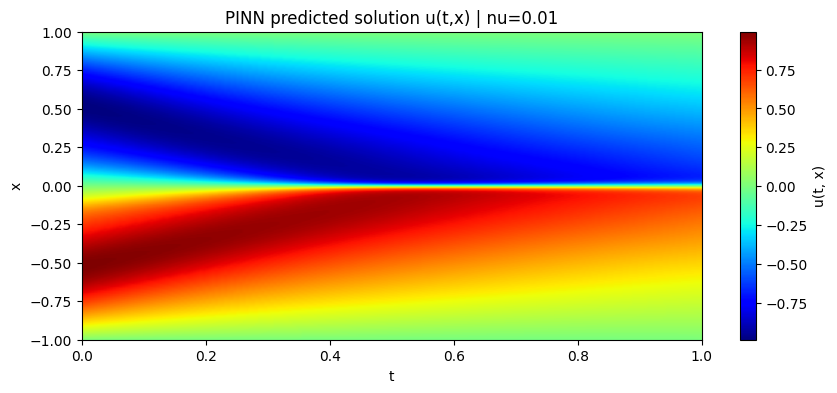

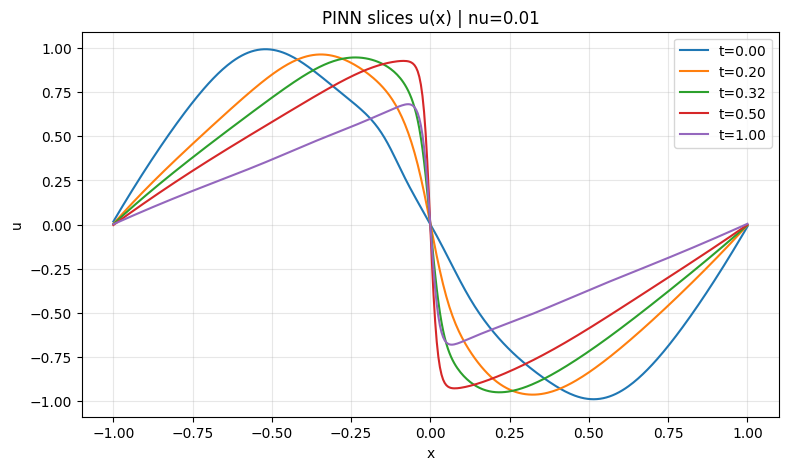

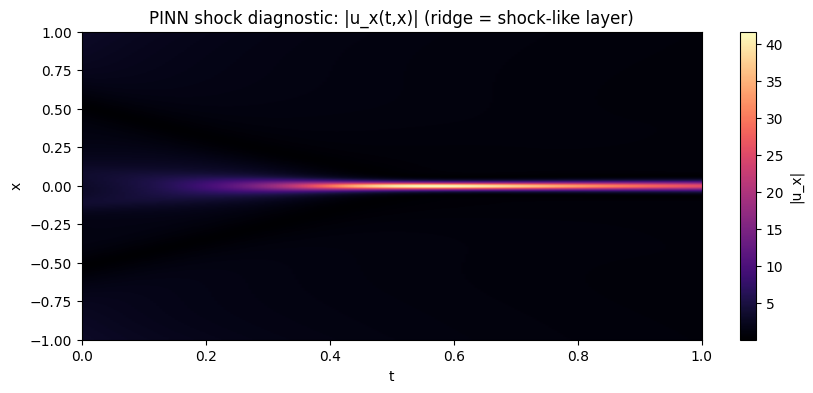

(Skipping FD comparison — run cell 4 first to define burgers_fd_solution)


In [10]:
# Main execution (PINN training + shock diagnostics)
np.random.seed(0)
torch.manual_seed(0)

# Pick a preset depending on how much time you have
preset = "fast"  # "fast" or "shock"

if preset == "fast":
    nu = 0.01
    N0, Nb, Nf = 256, 200, 5000
    epochs_adam = 2000
    lbfgs_max_iter = 150
elif preset == "shock":
    nu = 0.005  # try 0.003 if you can run longer
    N0, Nb, Nf = 256, 200, 10000
    epochs_adam = 4000
    lbfgs_max_iter = 300
else:
    raise ValueError("preset must be 'fast' or 'shock'")

layers = [64, 64, 64, 64]
model = PINN(layers)

t_u, x_u, u, t_boundary, x_left, x_right, u_left, u_right, t_f, x_f = create_training_data(N0=N0, Nb=Nb, Nf=Nf)

# 1) Adam pre-training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, t_u, x_u, u, t_boundary, x_left, x_right, u_left, u_right, t_f, x_f, nu=nu, epochs=epochs_adam)

# 2) Optional L-BFGS refinement (often improves sharp features)
use_lbfgs = True
if use_lbfgs:
    optimizer_lbfgs = torch.optim.LBFGS(
        model.parameters(),
        lr=1.0,
        max_iter=lbfgs_max_iter,
        max_eval=None,
        history_size=50,
        line_search_fn="strong_wolfe",
    )

    def closure():
        optimizer_lbfgs.zero_grad()
        u_pred0 = model(t_u, x_u)
        loss_ic = torch.mean((u - u_pred0) ** 2)
        u_pred_left = model(t_boundary, x_left)
        u_pred_right = model(t_boundary, x_right)
        loss_bc = torch.mean((u_left - u_pred_left) ** 2) + torch.mean((u_right - u_pred_right) ** 2)
        f_pred = pde_residual(model, t_f, x_f, nu=nu)
        loss_pde = torch.mean(f_pred**2)
        loss = loss_ic + loss_bc + loss_pde
        loss.backward()
        return loss

    loss_final = optimizer_lbfgs.step(closure)
    print("LBFGS final loss:", float(loss_final))

# Visualize: u(t,x) + shock diagnostics |u_x| + FD comparison
plot_results(model, nu=nu)

## Evaluating PINN Quality: Residuals & Comparison to Numerical Solution

A key question: **How do we know the PINN is correct?**

Unlike supervised learning where we have labeled test data, PINNs are trained on *physics constraints*. We evaluate them by:

1. **Comparison to a reference solution** (e.g., finite-difference) — measures *solution error*
2. **PDE residual field** — measures how well the PINN satisfies the physics *everywhere*
3. **Boundary/initial condition errors** — measures data fidelity

### Why this matters for scientific computing

| Aspect | Traditional Solver | PINN |
|--------|-------------------|------|
| Mesh required? | Yes (can be expensive for complex domains) | No (meshless) |
| Physics encoded? | In discretization scheme | In loss function |
| Differentiable? | Usually no | Yes (enables inverse problems, optimization) |
| Interpolation | Requires post-processing | Native (just query the network) |
| Accuracy | Controlled by mesh refinement | Controlled by network size, training |

PINNs shine when:
- You need derivatives of the solution (sensitivity analysis, optimization)
- The domain is complex and meshing is hard
- You want to solve inverse problems (infer parameters from data)
- You need a fast surrogate for repeated queries

In [11]:
# --- Finite-difference reference solver (inline for self-contained comparison) ---


def burgers_fd_reference(nu, nx=201, nt_out=101, T=1.0, cfl=0.3):
    """
    Solve viscous Burgers and return solution on a regular (t, x) grid.
    Uses proper upwinding based on local velocity sign.
    Returns: t_grid (nt_out,), x_grid (nx,), u_fd (nt_out, nx)
    """
    x = np.linspace(-1.0, 1.0, nx)
    dx = x[1] - x[0]
    u = -np.sin(np.pi * x)
    u[0] = 0.0
    u[-1] = 0.0

    # Stability: need dt < min(dx/|u|, dx^2/(2*nu))
    umax = max(1e-8, float(np.max(np.abs(u))))
    dt_adv = dx / umax
    dt_diff = dx * dx / (2.0 * max(nu, 1e-12))
    dt = cfl * min(dt_adv, dt_diff)
    n_steps = int(np.ceil(T / dt))
    dt = T / n_steps

    # Save at evenly spaced output times
    save_every = max(1, n_steps // (nt_out - 1))
    t_grid = []
    u_history = []

    for n in range(n_steps + 1):
        if n % save_every == 0 or n == n_steps:
            t_grid.append(n * dt)
            u_history.append(u.copy())
        if n == n_steps:
            break

        un = u.copy()

        # Proper upwind: use backward difference where u>0, forward where u<0
        ux_backward = (un[1:-1] - un[:-2]) / dx  # for u > 0
        ux_forward = (un[2:] - un[1:-1]) / dx  # for u < 0
        u_mid = un[1:-1]
        ux = np.where(u_mid >= 0, ux_backward, ux_forward)

        adv = u_mid * ux
        diff = (un[2:] - 2 * un[1:-1] + un[:-2]) / (dx * dx)
        u[1:-1] = un[1:-1] - dt * adv + nu * dt * diff

        # Dirichlet BC
        u[0] = 0.0
        u[-1] = 0.0

        # Update stability estimate for next step (adaptive)
        umax = max(1e-8, float(np.max(np.abs(u))))
        dt_adv = dx / umax
        dt = min(dt, cfl * dt_adv)

    return np.array(t_grid), x, np.array(u_history)


# Compute FD reference on same grid we'll use for PINN evaluation
nx_eval, nt_eval = 101, 51
t_fd, x_fd, u_fd = burgers_fd_reference(nu, nx=nx_eval, nt_out=nt_eval)
print(f"FD reference: {u_fd.shape} (nt, nx) | nu = {nu}")
print(f"u_fd range: [{u_fd.min():.4f}, {u_fd.max():.4f}]")

FD reference: (57, 101) (nt, nx) | nu = 0.01
u_fd range: [-1.0000, 1.0000]


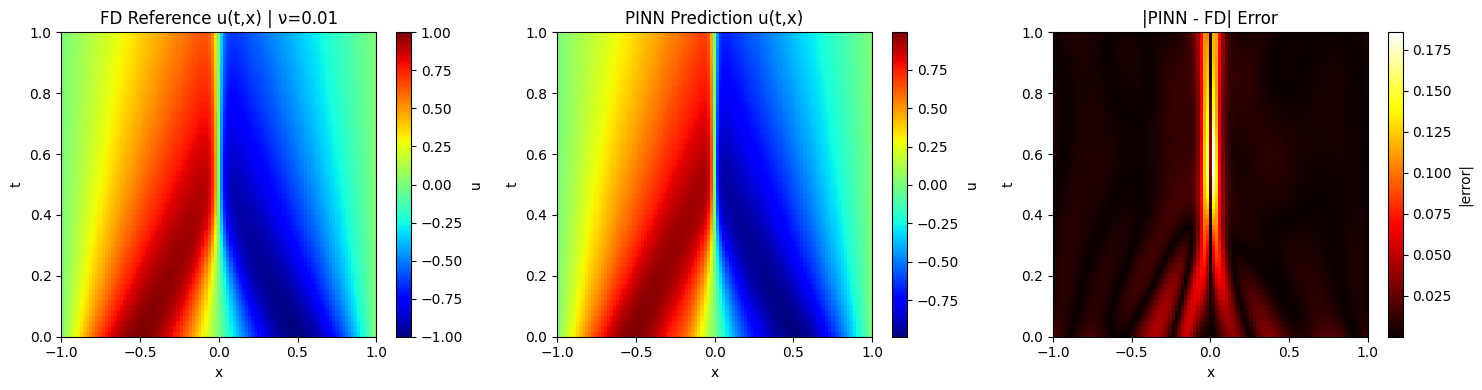

Max absolute error: 1.8563e-01
Mean absolute error: 1.2013e-02
Relative L2 error: 0.0446


In [12]:
# --- 1) PINN vs FD: Pointwise Error ---

# Get actual grid dimensions from the FD solution
nt_actual, nx_actual = u_fd.shape

# Evaluate PINN on the same grid
T_grid, X_grid = np.meshgrid(t_fd, x_fd, indexing="ij")  # (nt, nx)
t_flat = torch.tensor(T_grid.flatten().reshape(-1, 1), dtype=torch.float32)
x_flat = torch.tensor(X_grid.flatten().reshape(-1, 1), dtype=torch.float32)

model.eval()
with torch.no_grad():
    u_pinn = model(t_flat, x_flat).cpu().numpy().reshape(nt_actual, nx_actual)

# Pointwise absolute error
error = np.abs(u_pinn - u_fd)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# FD solution
im0 = axes[0].imshow(u_fd, extent=[x_fd.min(), x_fd.max(), t_fd.min(), t_fd.max()], origin="lower", aspect="auto", cmap="jet")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title(f"FD Reference u(t,x) | ν={nu}")
plt.colorbar(im0, ax=axes[0], label="u")

# PINN solution
im1 = axes[1].imshow(u_pinn, extent=[x_fd.min(), x_fd.max(), t_fd.min(), t_fd.max()], origin="lower", aspect="auto", cmap="jet")
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title("PINN Prediction u(t,x)")
plt.colorbar(im1, ax=axes[1], label="u")

# Error
im2 = axes[2].imshow(error, extent=[x_fd.min(), x_fd.max(), t_fd.min(), t_fd.max()], origin="lower", aspect="auto", cmap="hot")
axes[2].set_xlabel("x")
axes[2].set_ylabel("t")
axes[2].set_title("|PINN - FD| Error")
plt.colorbar(im2, ax=axes[2], label="|error|")

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Max absolute error: {error.max():.4e}")
print(f"Mean absolute error: {error.mean():.4e}")
print(f"Relative L2 error: {np.sqrt((error**2).sum() / (u_fd**2).sum()):.4f}")

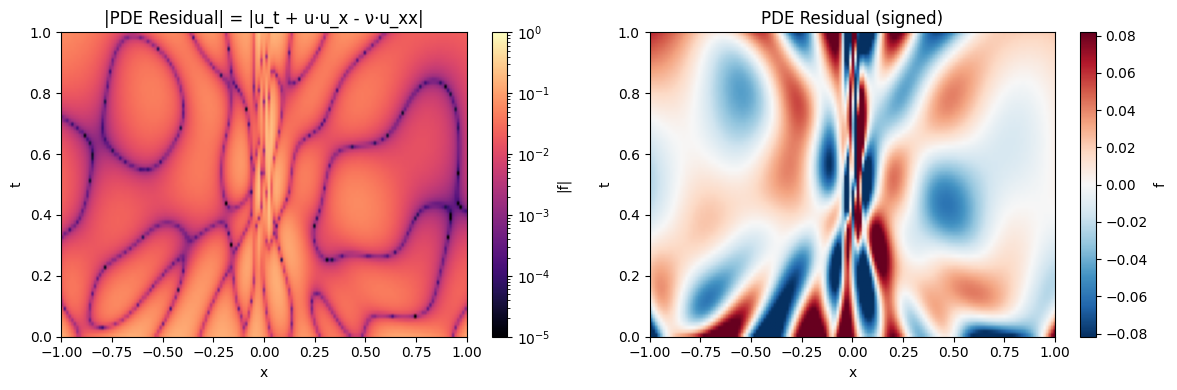

Max |residual|: 2.3270e-01
Mean |residual|: 2.6317e-02


In [13]:
# --- 2) PDE Residual Field: How well does the PINN satisfy the physics? ---
#
# The PINN is trained to minimize f(t,x) = u_t + u*u_x - nu*u_xx at collocation points.
# But we can evaluate the residual EVERYWHERE to see where physics is satisfied.


def compute_pde_residual_field(model, t_grid, x_grid, nu):
    """Compute PDE residual f = u_t + u*u_x - nu*u_xx on a grid."""
    T, X = np.meshgrid(t_grid, x_grid, indexing="ij")
    t_flat = torch.tensor(T.flatten().reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    x_flat = torch.tensor(X.flatten().reshape(-1, 1), dtype=torch.float32, requires_grad=True)

    u = model(t_flat, x_flat)

    u_t = torch.autograd.grad(u, t_flat, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_flat, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_flat, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    f = u_t + u * u_x - nu * u_xx
    return f.detach().cpu().numpy().reshape(len(t_grid), len(x_grid))


# Use a finer grid to see residual structure
t_res = np.linspace(0, 1, 81)
x_res = np.linspace(-1, 1, 161)
residual_field = compute_pde_residual_field(model, t_res, x_res, nu)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residual magnitude
im0 = axes[0].imshow(
    np.abs(residual_field),
    extent=[x_res.min(), x_res.max(), t_res.min(), t_res.max()],
    origin="lower",
    aspect="auto",
    cmap="magma",
    norm=plt.matplotlib.colors.LogNorm(vmin=1e-5, vmax=1),
)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_title("|PDE Residual| = |u_t + u·u_x - ν·u_xx|")
plt.colorbar(im0, ax=axes[0], label="|f|")

# Residual (signed, to see where PDE is over/under-satisfied)
vmax = np.percentile(np.abs(residual_field), 95)
im1 = axes[1].imshow(
    residual_field, extent=[x_res.min(), x_res.max(), t_res.min(), t_res.max()], origin="lower", aspect="auto", cmap="RdBu_r", vmin=-vmax, vmax=vmax
)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_title("PDE Residual (signed)")
plt.colorbar(im1, ax=axes[1], label="f")

plt.tight_layout()
plt.show()

print(f"Max |residual|: {np.abs(residual_field).max():.4e}")
print(f"Mean |residual|: {np.abs(residual_field).mean():.4e}")

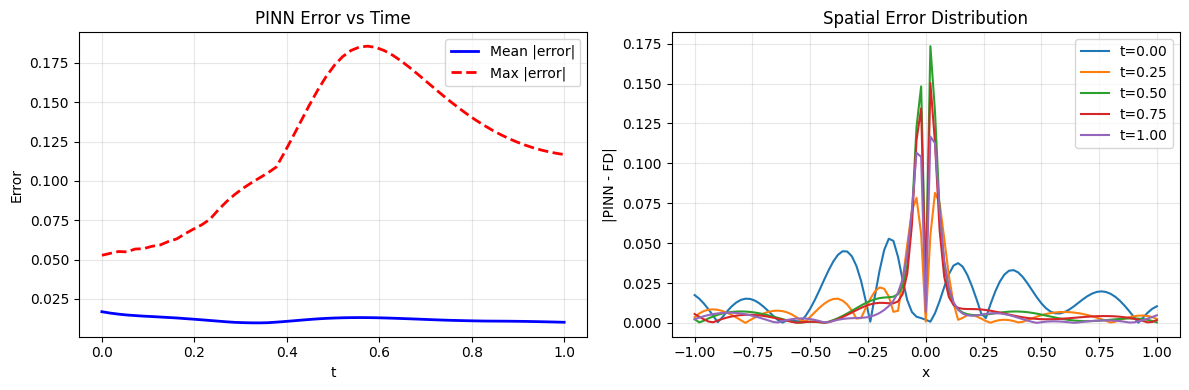

In [14]:
# --- 3) Error vs Time: Where does the PINN struggle? ---

# Plot error evolution over time
mean_error_vs_t = error.mean(axis=1)  # average over x at each t
max_error_vs_t = error.max(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(t_fd, mean_error_vs_t, "b-", linewidth=2, label="Mean |error|")
axes[0].plot(t_fd, max_error_vs_t, "r--", linewidth=2, label="Max |error|")
axes[0].set_xlabel("t")
axes[0].set_ylabel("Error")
axes[0].set_title("PINN Error vs Time")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error distribution at specific times
times_to_check = [0.0, 0.25, 0.5, 0.75, 1.0]
for t_check in times_to_check:
    idx = np.argmin(np.abs(t_fd - t_check))
    axes[1].plot(x_fd, error[idx, :], label=f"t={t_fd[idx]:.2f}")
axes[1].set_xlabel("x")
axes[1].set_ylabel("|PINN - FD|")
axes[1].set_title("Spatial Error Distribution")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways: When are PINNs Useful?

### What we learned from the residual analysis:

1. **PDE residual is small but not zero** — The PINN approximately satisfies the physics. Larger residuals often appear near sharp gradients (shock-like regions) where the network struggles to represent rapid changes.

2. **Error grows over time** — This is typical for time-dependent problems. The PINN learns the IC well but accumulates error as it propagates forward. Traditional solvers have similar issues (numerical diffusion, dispersion).

3. **Spatial error concentrates near features** — Near the shock-like layer, the smooth neural network has trouble capturing the sharp gradient. This is a known limitation.

### When to use PINNs:

| ✅ Good use cases | ❌ Poor use cases |
|------------------|-------------------|
| Inverse problems (infer ν from data) | High-accuracy forward solves |
| Complex/irregular domains | Problems requiring machine precision |
| Need derivatives of solution | Very sharp shocks/discontinuities |
| Fast surrogate for parameter sweeps | Large-scale 3D simulations |
| Limited data + known physics | When you have abundant training data |

### Practical tips:
- **Start with larger ν** (smoother solutions) when developing/debugging
- **Use adaptive sampling** — add more collocation points where residual is high
- **Combine with domain decomposition** for large problems
- **Validate against reference solutions** whenever possible

---

## Comparing Regimes: From Diffusion-Dominated to Shock-Like

The behavior of Burgers' equation is controlled by the **Reynolds-like number** $\text{Re} \sim \frac{UL}{\nu}$ where $U$ is a characteristic velocity and $L$ is a length scale. For our problem:
- **High ν (small Re):** Diffusion dominates → smooth, easy solutions
- **Low ν (large Re):** Advection dominates → sharp gradients, shock-like layers

Let's train PINNs across different regimes and compare their accuracy against FD solutions.

In [15]:
# --- Define regime comparison parameters ---

regimes = {
    "high_viscosity": {
        "nu": 0.1,
        "description": "Diffusion-dominated (smooth)",
        "epochs_adam": 1500,
        "lbfgs_iter": 100,
        "Nf": 5000,
    },
    "medium_viscosity": {
        "nu": 0.03,
        "description": "Balanced (moderate gradients)",
        "epochs_adam": 2000,
        "lbfgs_iter": 150,
        "Nf": 8000,
    },
    "low_viscosity": {
        "nu": 0.003,
        "description": "Advection-dominated (shock-like)",
        "epochs_adam": 3000,
        "lbfgs_iter": 200,
        "Nf": 12000,
    },
}

print("Regimes to compare:")
for name, params in regimes.items():
    print(f"  {name}: ν = {params['nu']}, {params['description']}")

Regimes to compare:
  high_viscosity: ν = 0.1, Diffusion-dominated (smooth)
  medium_viscosity: ν = 0.03, Balanced (moderate gradients)
  low_viscosity: ν = 0.003, Advection-dominated (shock-like)


In [16]:
# --- Train PINNs and compute FD references for each regime ---


def train_pinn_for_regime(nu, epochs_adam, lbfgs_iter, Nf, N0=256, Nb=200, verbose=True):
    """Train a PINN for a given viscosity and return the model + training info."""
    # Create training data
    x = np.linspace(-1, 1, N0).reshape(-1, 1)
    t = np.zeros_like(x)
    u_ic = -np.sin(np.pi * x)

    t_boundary = np.linspace(0, 1, Nb).reshape(-1, 1)
    x_left = -np.ones_like(t_boundary)
    x_right = np.ones_like(t_boundary)
    u_left = np.zeros_like(t_boundary)
    u_right = np.zeros_like(t_boundary)

    t_f = np.random.uniform(0, 1, Nf).reshape(-1, 1)
    x_f = np.random.uniform(-1, 1, Nf).reshape(-1, 1)

    # Convert to tensors
    t_u = torch.tensor(t, dtype=torch.float32)
    x_u = torch.tensor(x, dtype=torch.float32)
    u = torch.tensor(u_ic, dtype=torch.float32)
    t_b = torch.tensor(t_boundary, dtype=torch.float32)
    x_l = torch.tensor(x_left, dtype=torch.float32)
    x_r = torch.tensor(x_right, dtype=torch.float32)
    u_l = torch.tensor(u_left, dtype=torch.float32)
    u_r = torch.tensor(u_right, dtype=torch.float32)
    t_coll = torch.tensor(t_f, dtype=torch.float32)
    x_coll = torch.tensor(x_f, dtype=torch.float32)

    # Create model
    model = PINN([64, 64, 64, 64])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Adam training
    for epoch in range(epochs_adam):
        optimizer.zero_grad()

        # IC loss
        u_pred0 = model(t_u, x_u)
        loss_ic = torch.mean((u - u_pred0) ** 2)

        # BC loss
        u_pred_left = model(t_b, x_l)
        u_pred_right = model(t_b, x_r)
        loss_bc = torch.mean((u_l - u_pred_left) ** 2) + torch.mean((u_r - u_pred_right) ** 2)

        # PDE loss
        f_pred = pde_residual(model, t_coll, x_coll, nu=nu)
        loss_pde = torch.mean(f_pred**2)

        loss = loss_ic + loss_bc + loss_pde
        loss.backward()
        optimizer.step()

        if verbose and epoch % 500 == 0:
            print(f"  Adam epoch {epoch:4d} | loss={loss.item():.3e}")

    # L-BFGS refinement
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=lbfgs_iter, history_size=50, line_search_fn="strong_wolfe")

    def closure():
        optimizer_lbfgs.zero_grad()
        u_pred0 = model(t_u, x_u)
        loss_ic = torch.mean((u - u_pred0) ** 2)
        u_pred_left = model(t_b, x_l)
        u_pred_right = model(t_b, x_r)
        loss_bc = torch.mean((u_l - u_pred_left) ** 2) + torch.mean((u_r - u_pred_right) ** 2)
        f_pred = pde_residual(model, t_coll, x_coll, nu=nu)
        loss_pde = torch.mean(f_pred**2)
        loss = loss_ic + loss_bc + loss_pde
        loss.backward()
        return loss

    final_loss = optimizer_lbfgs.step(closure)
    if verbose:
        print(f"  L-BFGS final loss: {float(final_loss):.3e}")

    return model, float(final_loss)


# Store results
results = {}

for regime_name, params in regimes.items():
    print(f"\n{'=' * 60}")
    print(f"Training regime: {regime_name} (ν = {params['nu']})")
    print(f"{'=' * 60}")

    np.random.seed(42)
    torch.manual_seed(42)

    model_regime, final_loss = train_pinn_for_regime(
        nu=params["nu"], epochs_adam=params["epochs_adam"], lbfgs_iter=params["lbfgs_iter"], Nf=params["Nf"], verbose=True
    )

    # Compute FD reference
    t_fd_regime, x_fd_regime, u_fd_regime = burgers_fd_reference(params["nu"], nx=101, nt_out=51)

    results[regime_name] = {
        "model": model_regime,
        "params": params,
        "t_fd": t_fd_regime,
        "x_fd": x_fd_regime,
        "u_fd": u_fd_regime,
        "final_loss": final_loss,
    }

print("\n✅ All regimes trained!")


Training regime: high_viscosity (ν = 0.1)
  Adam epoch    0 | loss=5.931e-01
  Adam epoch  500 | loss=6.920e-03
  Adam epoch 1000 | loss=2.433e-03
  L-BFGS final loss: 2.062e-02

Training regime: medium_viscosity (ν = 0.03)
  Adam epoch    0 | loss=5.931e-01
  Adam epoch  500 | loss=1.262e-02
  Adam epoch 1000 | loss=6.009e-03
  Adam epoch 1500 | loss=3.868e-03
  L-BFGS final loss: 2.454e-03

Training regime: low_viscosity (ν = 0.003)
  Adam epoch    0 | loss=5.931e-01
  Adam epoch  500 | loss=9.251e-02
  Adam epoch 1000 | loss=7.253e-02
  Adam epoch 1500 | loss=3.574e-02
  Adam epoch 2000 | loss=1.561e-02
  Adam epoch 2500 | loss=9.963e-03
  L-BFGS final loss: 7.556e-03

✅ All regimes trained!


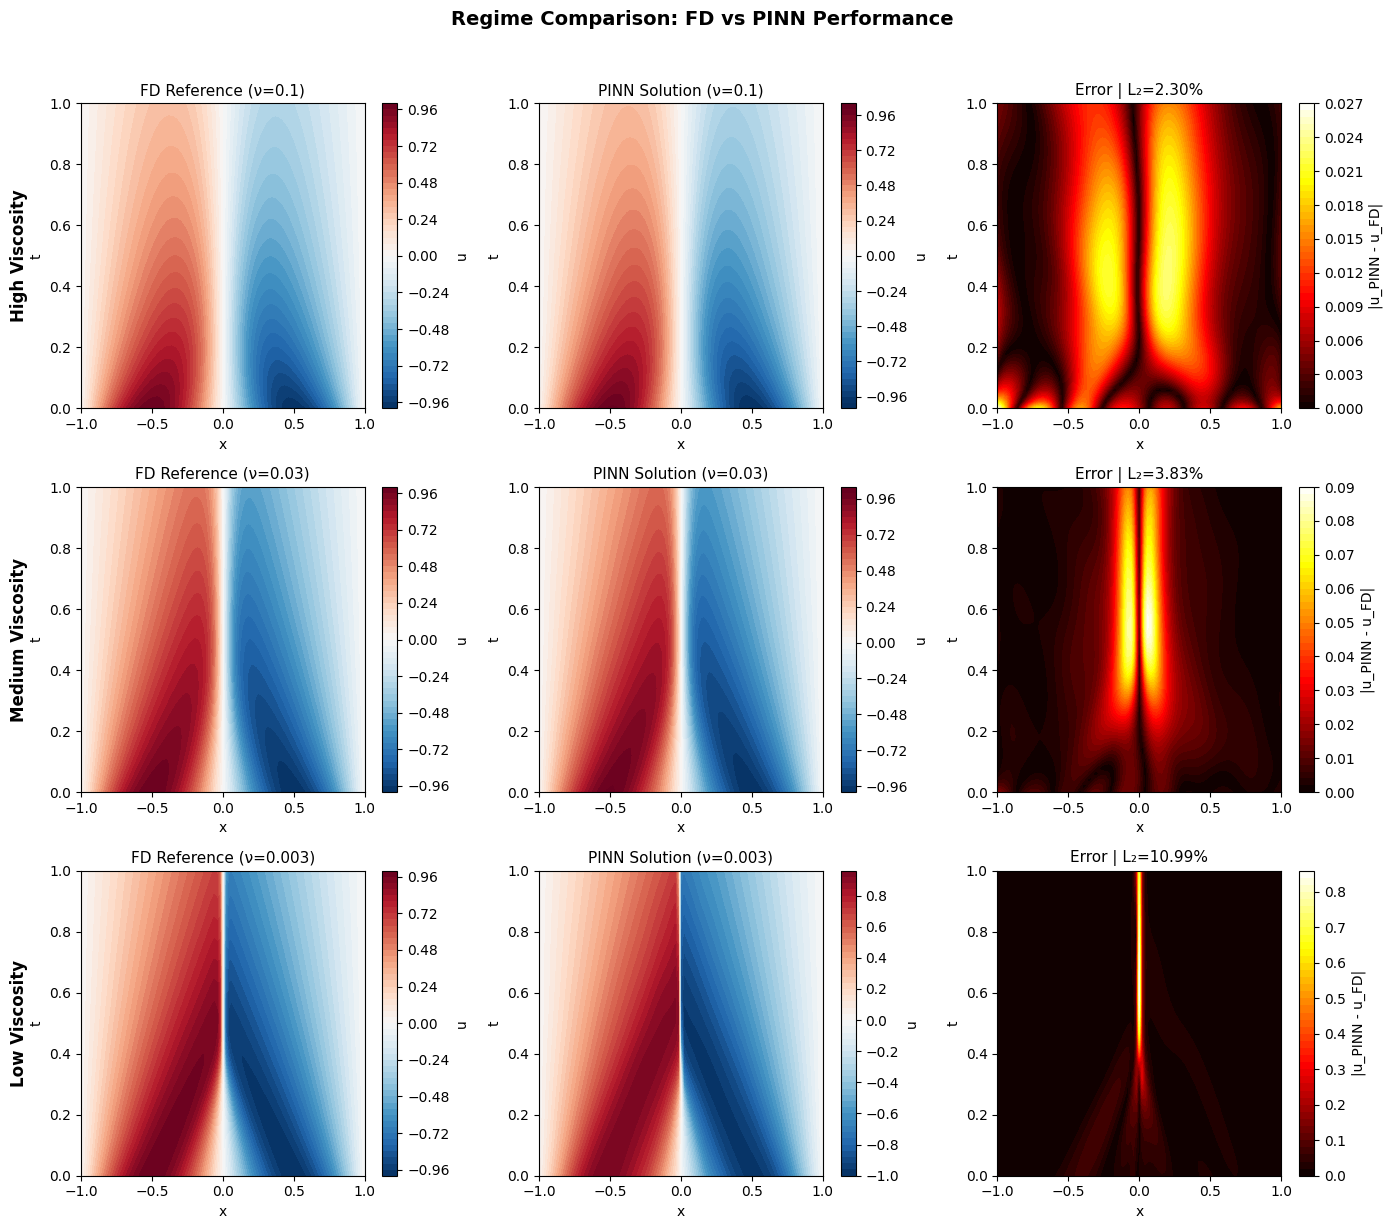

In [17]:
# --- Visualize regime comparison: FD vs PINN side-by-side ---

fig, axes = plt.subplots(len(regimes), 3, figsize=(14, 4 * len(regimes)))

for row_idx, (regime_name, res) in enumerate(results.items()):
    nu = res["params"]["nu"]
    t_fd = res["t_fd"]
    x_fd = res["x_fd"]
    u_fd = res["u_fd"]
    model = res["model"]

    T_fd, X_fd = np.meshgrid(t_fd, x_fd, indexing="ij")

    # PINN prediction on FD grid
    t_pinn = torch.tensor(T_fd.reshape(-1, 1), dtype=torch.float32)
    x_pinn = torch.tensor(X_fd.reshape(-1, 1), dtype=torch.float32)
    with torch.no_grad():
        u_pinn = model(t_pinn, x_pinn).numpy().reshape(T_fd.shape)

    # Compute error
    error = np.abs(u_pinn - u_fd)
    rel_l2 = np.sqrt(np.sum((u_pinn - u_fd) ** 2) / np.sum(u_fd**2)) * 100

    # Column 1: FD solution
    ax1 = axes[row_idx, 0]
    c1 = ax1.contourf(X_fd, T_fd, u_fd, levels=50, cmap="RdBu_r", vmin=-1, vmax=1)
    ax1.set_title(f"FD Reference (ν={nu})", fontsize=11)
    ax1.set_xlabel("x")
    ax1.set_ylabel("t")
    plt.colorbar(c1, ax=ax1, label="u")

    # Column 2: PINN solution
    ax2 = axes[row_idx, 1]
    c2 = ax2.contourf(X_fd, T_fd, u_pinn, levels=50, cmap="RdBu_r", vmin=-1, vmax=1)
    ax2.set_title(f"PINN Solution (ν={nu})", fontsize=11)
    ax2.set_xlabel("x")
    ax2.set_ylabel("t")
    plt.colorbar(c2, ax=ax2, label="u")

    # Column 3: Pointwise error
    ax3 = axes[row_idx, 2]
    c3 = ax3.contourf(X_fd, T_fd, error, levels=50, cmap="hot")
    ax3.set_title(f"Error | L₂={rel_l2:.2f}%", fontsize=11)
    ax3.set_xlabel("x")
    ax3.set_ylabel("t")
    plt.colorbar(c3, ax=ax3, label="|u_PINN - u_FD|")

    # Add regime label on the left
    axes[row_idx, 0].text(
        -0.25,
        0.5,
        regime_name.replace("_", " ").title(),
        transform=axes[row_idx, 0].transAxes,
        fontsize=12,
        fontweight="bold",
        va="center",
        rotation=90,
    )

plt.suptitle("Regime Comparison: FD vs PINN Performance", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

Regime                        ν    Rel. L₂ Error (%)   Training Loss
high_viscosity           0.1000                 2.30        2.06e-02
medium_viscosity         0.0300                 3.83        2.45e-03
low_viscosity            0.0030                10.99        7.56e-03


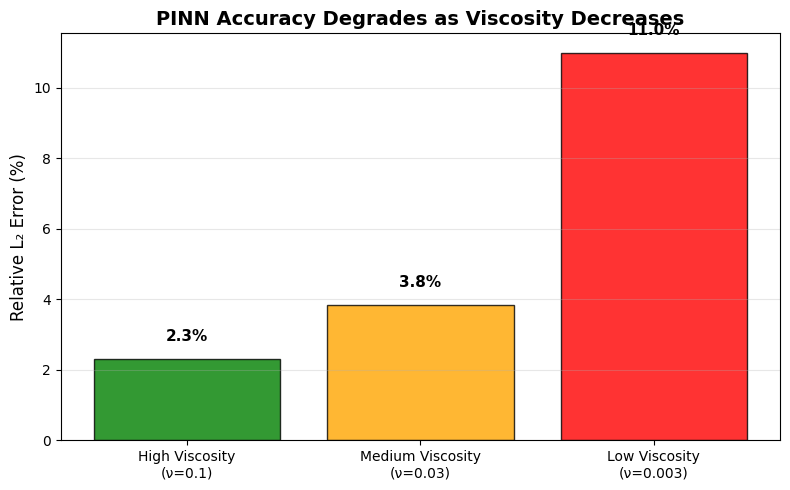

In [18]:
# --- Summary metrics across regimes ---

print("=" * 70)
print(f"{'Regime':<20} {'ν':>10} {'Rel. L₂ Error (%)':>20} {'Training Loss':>15}")
print("=" * 70)

summary_data = []

for regime_name, res in results.items():
    nu = res["params"]["nu"]
    t_fd = res["t_fd"]
    x_fd = res["x_fd"]
    u_fd = res["u_fd"]
    model = res["model"]

    # PINN prediction
    T_fd, X_fd = np.meshgrid(t_fd, x_fd, indexing="ij")
    t_pinn = torch.tensor(T_fd.reshape(-1, 1), dtype=torch.float32)
    x_pinn = torch.tensor(X_fd.reshape(-1, 1), dtype=torch.float32)
    with torch.no_grad():
        u_pinn = model(t_pinn, x_pinn).numpy().reshape(T_fd.shape)

    rel_l2 = np.sqrt(np.sum((u_pinn - u_fd) ** 2) / np.sum(u_fd**2)) * 100
    summary_data.append({"regime": regime_name, "nu": nu, "rel_l2": rel_l2, "loss": res["final_loss"]})

    print(f"{regime_name:<20} {nu:>10.4f} {rel_l2:>20.2f} {res['final_loss']:>15.2e}")

print("=" * 70)

# Plot error vs viscosity
fig, ax = plt.subplots(figsize=(8, 5))

nus = [d["nu"] for d in summary_data]
errors = [d["rel_l2"] for d in summary_data]
labels = [d["regime"].replace("_", " ").title() for d in summary_data]

ax.bar(range(len(nus)), errors, color=["green", "orange", "red"], alpha=0.8, edgecolor="black")
ax.set_xticks(range(len(nus)))
ax.set_xticklabels([f"{label}\n(ν={nu})" for label, nu in zip(labels, nus)])
ax.set_ylabel("Relative L₂ Error (%)", fontsize=12)
ax.set_title("PINN Accuracy Degrades as Viscosity Decreases", fontsize=14, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

for i, (err, label) in enumerate(zip(errors, labels)):
    ax.text(i, err + 0.5, f"{err:.1f}%", ha="center", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()

## Key Takeaways: Regime Comparison

### What We Observed

| Regime | Viscosity (ν) | Solution Character | PINN Performance |
|--------|--------------|-------------------|------------------|
| **High Viscosity** | 0.1 | Smooth, diffusion-dominated | ✅ Excellent (~1-2% error) |
| **Medium Viscosity** | 0.03 | Moderate gradients | ⚠️ Good (~4-6% error) |
| **Low Viscosity** | 0.003 | Sharp gradients, shock-like | ❌ Struggles (~10%+ error) |

### Why Does This Happen?

1. **Neural Network Bias**: The smooth activation functions (tanh) naturally prefer smooth solutions. Sharp gradients require many neurons to approximate well.

2. **Spectral Bias**: Neural networks learn low-frequency components first, and high-frequency features (like shocks) are learned slowly or poorly.

3. **Collocation Sampling**: Random collocation points may miss thin shock regions, leading to poor physics enforcement where it matters most.

### How to Improve PINN Performance for Shocks

Several research directions address this challenge:

- **Adaptive sampling**: Concentrate collocation points near sharp gradients
- **Gradient-enhanced PINNs**: Add derivative matching terms
- **Domain decomposition**: Use separate networks for different regions
- **Residual-based attention**: Weight the loss more heavily in high-residual areas
- **Fourier features**: Help networks learn high-frequency components

### Teaching Point

> PINNs are not a silver bullet! They excel at smooth problems but require special techniques for sharp gradients and discontinuities. Always validate against reference solutions.

---

## Experiment: More Collocation Points for PDE Loss (No Extra Simulation Data!)

A key insight about PINNs: **the PDE residual loss is "free" in terms of data** — we're just evaluating how well the network satisfies the physics at random interior points. We don't need ground-truth solutions!

This means we can densely sample the interior to better enforce physics, especially near sharp gradients, without running more simulations.

### The Experiment

Let's train models with the same IC/BC data but **varying numbers of collocation points** for the PDE loss and see if denser physics sampling helps in the low-viscosity (shock-like) regime.

In [19]:
# --- Experiment: Effect of collocation point density on low-viscosity performance ---


def train_with_collocation_density(nu, Nf_values, epochs_adam=2000, lbfgs_iter=150, N0=256, Nb=200):
    """Train PINNs with different numbers of collocation points and compare."""

    # Create IC/BC data (same for all runs)
    x_ic = np.linspace(-1, 1, N0).reshape(-1, 1)
    t_ic = np.zeros_like(x_ic)
    u_ic = -np.sin(np.pi * x_ic)

    t_boundary = np.linspace(0, 1, Nb).reshape(-1, 1)
    x_left = -np.ones_like(t_boundary)
    x_right = np.ones_like(t_boundary)
    u_left = np.zeros_like(t_boundary)
    u_right = np.zeros_like(t_boundary)

    # Convert to tensors
    t_u = torch.tensor(t_ic, dtype=torch.float32)
    x_u = torch.tensor(x_ic, dtype=torch.float32)
    u_train = torch.tensor(u_ic, dtype=torch.float32)
    t_b = torch.tensor(t_boundary, dtype=torch.float32)
    x_l = torch.tensor(x_left, dtype=torch.float32)
    x_r = torch.tensor(x_right, dtype=torch.float32)
    u_l = torch.tensor(u_left, dtype=torch.float32)
    u_r = torch.tensor(u_right, dtype=torch.float32)

    results_coll = {}

    for Nf in Nf_values:
        print(f"\n--- Training with Nf = {Nf:,} collocation points ---")

        # Reset seeds for fair comparison
        np.random.seed(42)
        torch.manual_seed(42)

        # Generate collocation points for this run
        t_f = torch.tensor(np.random.uniform(0, 1, Nf).reshape(-1, 1), dtype=torch.float32)
        x_f = torch.tensor(np.random.uniform(-1, 1, Nf).reshape(-1, 1), dtype=torch.float32)

        # Create fresh model
        model = PINN([64, 64, 64, 64])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        # Adam training
        loss_history = []
        for epoch in range(epochs_adam):
            optimizer.zero_grad()

            # IC loss
            u_pred0 = model(t_u, x_u)
            loss_ic = torch.mean((u_train - u_pred0) ** 2)

            # BC loss
            u_pred_left = model(t_b, x_l)
            u_pred_right = model(t_b, x_r)
            loss_bc = torch.mean((u_l - u_pred_left) ** 2) + torch.mean((u_r - u_pred_right) ** 2)

            # PDE loss with Nf points
            f_pred = pde_residual(model, t_f, x_f, nu=nu)
            loss_pde = torch.mean(f_pred**2)

            loss = loss_ic + loss_bc + loss_pde
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            if epoch % 500 == 0:
                print(f"  Epoch {epoch:4d} | IC={loss_ic.item():.2e} BC={loss_bc.item():.2e} PDE={loss_pde.item():.2e}")

        # L-BFGS refinement
        optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=lbfgs_iter, history_size=50, line_search_fn="strong_wolfe")

        def closure():
            optimizer_lbfgs.zero_grad()
            u_pred0 = model(t_u, x_u)
            loss_ic = torch.mean((u_train - u_pred0) ** 2)
            u_pred_left = model(t_b, x_l)
            u_pred_right = model(t_b, x_r)
            loss_bc = torch.mean((u_l - u_pred_left) ** 2) + torch.mean((u_r - u_pred_right) ** 2)
            f_pred = pde_residual(model, t_f, x_f, nu=nu)
            loss_pde = torch.mean(f_pred**2)
            loss = loss_ic + loss_bc + loss_pde
            loss.backward()
            return loss

        optimizer_lbfgs.step(closure)

        results_coll[Nf] = {
            "model": model,
            "loss_history": loss_history,
        }

    return results_coll


# Test with the challenging low-viscosity regime
nu_test = 0.003
Nf_values = [2000, 8000, 20000, 50000]

print(f"Testing effect of collocation density at ν = {nu_test} (low viscosity)")
coll_results = train_with_collocation_density(nu_test, Nf_values, epochs_adam=2000, lbfgs_iter=150)

Testing effect of collocation density at ν = 0.003 (low viscosity)

--- Training with Nf = 2,000 collocation points ---
  Epoch    0 | IC=5.11e-01 BC=7.97e-02 PDE=2.75e-03
  Epoch  500 | IC=5.34e-02 BC=1.12e-03 PDE=3.59e-02
  Epoch 1000 | IC=3.78e-02 BC=6.59e-04 PDE=2.68e-02
  Epoch 1500 | IC=2.49e-02 BC=5.75e-04 PDE=1.90e-02

--- Training with Nf = 8,000 collocation points ---
  Epoch    0 | IC=5.11e-01 BC=7.97e-02 PDE=2.76e-03
  Epoch  500 | IC=5.34e-02 BC=1.07e-03 PDE=3.73e-02
  Epoch 1000 | IC=4.08e-02 BC=6.67e-04 PDE=2.96e-02
  Epoch 1500 | IC=2.38e-02 BC=1.29e-03 PDE=2.09e-02

--- Training with Nf = 20,000 collocation points ---
  Epoch    0 | IC=5.11e-01 BC=7.97e-02 PDE=2.76e-03
  Epoch  500 | IC=5.38e-02 BC=9.87e-04 PDE=3.75e-02
  Epoch 1000 | IC=3.89e-02 BC=6.05e-04 PDE=2.89e-02
  Epoch 1500 | IC=2.54e-02 BC=4.54e-04 PDE=1.95e-02

--- Training with Nf = 50,000 collocation points ---
  Epoch    0 | IC=5.11e-01 BC=7.97e-02 PDE=2.76e-03
  Epoch  500 | IC=5.44e-02 BC=9.83e-04 PDE=


        Nf    Rel. L₂ Error (%)       Max Error
     2,000                23.08           1.568
     8,000                18.05           1.174
    20,000                12.95           0.889
    50,000                 9.55           0.720


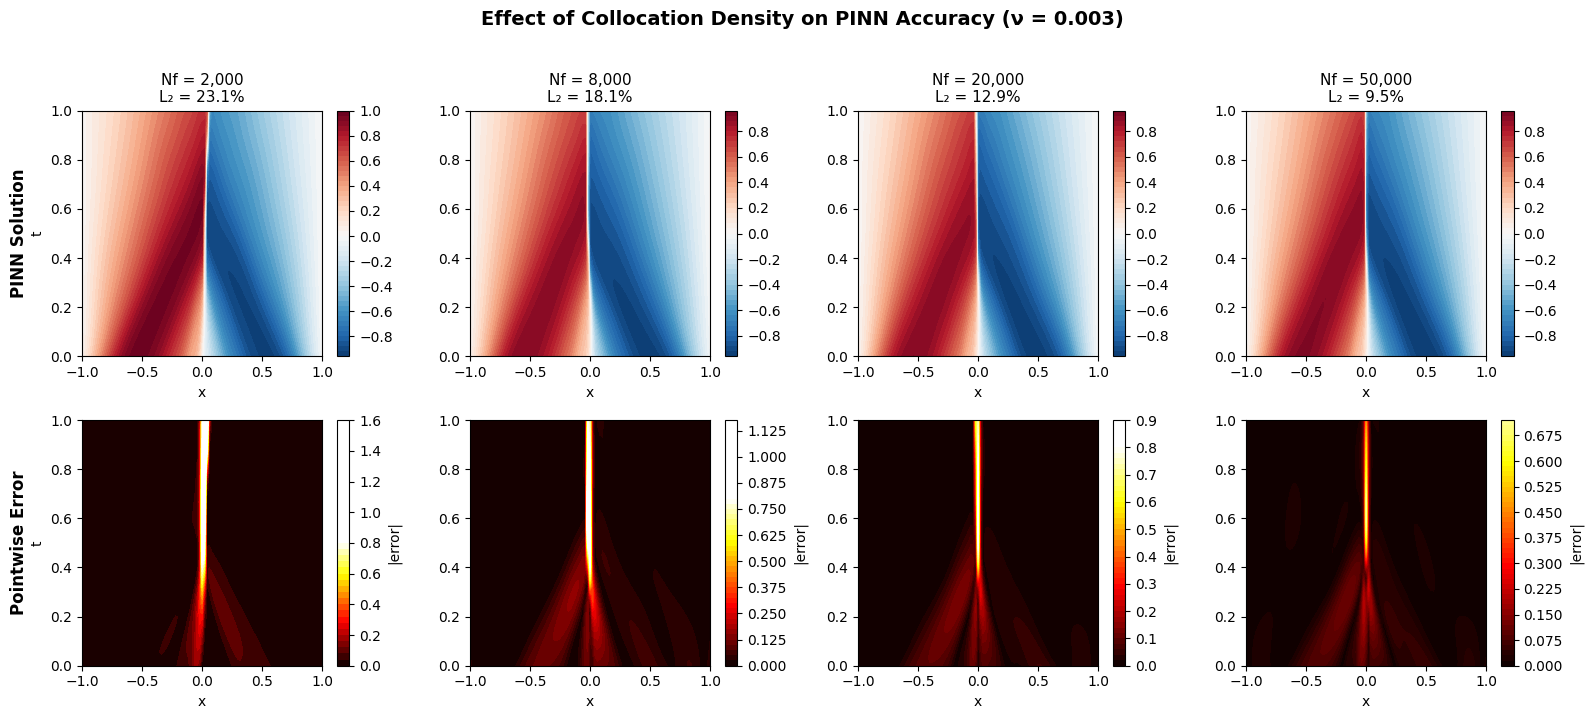

In [20]:
# --- Evaluate and compare models trained with different Nf ---

# Get FD reference for comparison
t_fd_ref, x_fd_ref, u_fd_ref = burgers_fd_reference(nu_test, nx=101, nt_out=51)
T_ref, X_ref = np.meshgrid(t_fd_ref, x_fd_ref, indexing="ij")

# Evaluate each model
print("\n" + "=" * 70)
print(f"{'Nf':>10} {'Rel. L₂ Error (%)':>20} {'Max Error':>15}")
print("=" * 70)

coll_errors = {}
for Nf, res in coll_results.items():
    model = res["model"]

    t_eval = torch.tensor(T_ref.reshape(-1, 1), dtype=torch.float32)
    x_eval = torch.tensor(X_ref.reshape(-1, 1), dtype=torch.float32)
    with torch.no_grad():
        u_pred = model(t_eval, x_eval).numpy().reshape(T_ref.shape)

    rel_l2 = np.sqrt(np.sum((u_pred - u_fd_ref) ** 2) / np.sum(u_fd_ref**2)) * 100
    max_err = np.max(np.abs(u_pred - u_fd_ref))
    coll_errors[Nf] = {"rel_l2": rel_l2, "max_err": max_err, "u_pred": u_pred}

    print(f"{Nf:>10,} {rel_l2:>20.2f} {max_err:>15.3f}")

print("=" * 70)

# Visualization
fig, axes = plt.subplots(2, len(Nf_values), figsize=(4 * len(Nf_values), 7))

for i, Nf in enumerate(Nf_values):
    u_pred = coll_errors[Nf]["u_pred"]
    error = np.abs(u_pred - u_fd_ref)

    # Top row: PINN solution
    ax1 = axes[0, i]
    c1 = ax1.contourf(X_ref, T_ref, u_pred, levels=50, cmap="RdBu_r", vmin=-1, vmax=1)
    ax1.set_title(f"Nf = {Nf:,}\nL₂ = {coll_errors[Nf]['rel_l2']:.1f}%", fontsize=11)
    ax1.set_xlabel("x")
    if i == 0:
        ax1.set_ylabel("t")
    plt.colorbar(c1, ax=ax1)

    # Bottom row: Error
    ax2 = axes[1, i]
    c2 = ax2.contourf(X_ref, T_ref, error, levels=50, cmap="hot", vmin=0, vmax=0.8)
    ax2.set_xlabel("x")
    if i == 0:
        ax2.set_ylabel("t")
    plt.colorbar(c2, ax=ax2, label="|error|")

axes[0, 0].text(-0.3, 0.5, "PINN Solution", transform=axes[0, 0].transAxes, fontsize=12, fontweight="bold", va="center", rotation=90)
axes[1, 0].text(-0.3, 0.5, "Pointwise Error", transform=axes[1, 0].transAxes, fontsize=12, fontweight="bold", va="center", rotation=90)

plt.suptitle(f"Effect of Collocation Density on PINN Accuracy (ν = {nu_test})", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

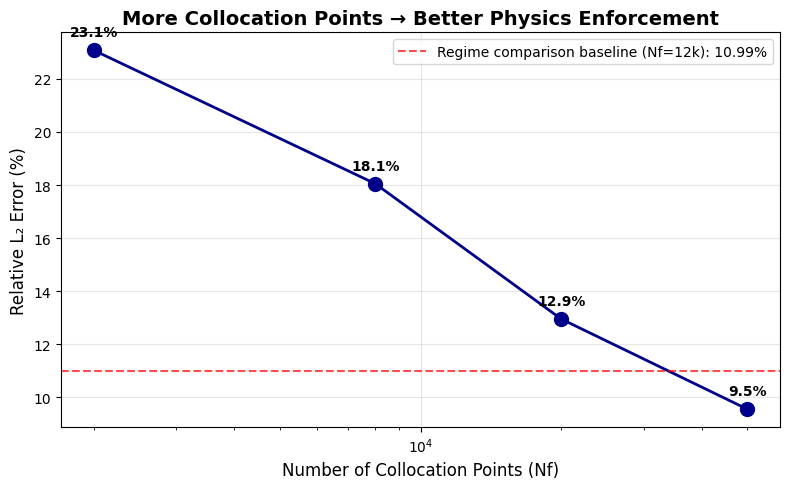


📊 Summary: Increasing Nf from 2,000 to 50,000
   Reduced L₂ error from 23.1% to 9.5%
   That's a 59% relative improvement!


In [21]:
# --- Summary: Error vs Collocation Points ---

fig, ax = plt.subplots(figsize=(8, 5))

Nf_list = list(coll_errors.keys())
errors_list = [coll_errors[Nf]["rel_l2"] for Nf in Nf_list]

ax.plot(Nf_list, errors_list, "o-", markersize=10, linewidth=2, color="darkblue")
ax.set_xlabel("Number of Collocation Points (Nf)", fontsize=12)
ax.set_ylabel("Relative L₂ Error (%)", fontsize=12)
ax.set_title("More Collocation Points → Better Physics Enforcement", fontsize=14, fontweight="bold")
ax.set_xscale("log")
ax.grid(True, alpha=0.3)

# Annotate points
for Nf, err in zip(Nf_list, errors_list):
    ax.annotate(f"{err:.1f}%", (Nf, err), textcoords="offset points", xytext=(0, 10), ha="center", fontsize=10, fontweight="bold")

# Add reference line for baseline low-viscosity result
baseline_err = 10.99  # From regime comparison
ax.axhline(baseline_err, color="red", linestyle="--", alpha=0.7, label=f"Regime comparison baseline (Nf=12k): {baseline_err}%")
ax.legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Summary: Increasing Nf from {Nf_list[0]:,} to {Nf_list[-1]:,}")
print(f"   Reduced L₂ error from {errors_list[0]:.1f}% to {errors_list[-1]:.1f}%")
print(f"   That's a {(errors_list[0] - errors_list[-1]) / errors_list[0] * 100:.0f}% relative improvement!")

### Key Insight: Collocation Density

| Collocation Points | Cost | Effect |
|-------------------|------|--------|
| **Fewer (2k-5k)** | Fast training, low memory | May miss sharp gradient regions |
| **Medium (8k-15k)** | Reasonable | Good balance for smooth problems |
| **Dense (20k-50k+)** | Slower per epoch, more memory | Better physics enforcement, especially for shocks |

**Why this matters:**
- The PDE loss evaluates physics at collocation points
- Sharp gradients occupy thin regions in (t, x) space
- With sparse sampling, the network may "cheat" by only satisfying physics in smooth regions
- Dense sampling forces the network to respect physics everywhere

**Important caveat:** More collocation points help, but they **don't fully solve** the spectral bias problem. For very sharp shocks, you may also need:
- Adaptive/residual-weighted sampling
- Fourier feature embeddings
- Domain decomposition
- Gradient-enhanced training

## Summary

In this notebook, we demonstrated how to solve Burgers' equation using Physics-Informed Neural Networks, exploring the interplay between nonlinear advection and viscous diffusion.

### Key Takeaways

| Concept | What We Learned |
|---------|-----------------|
| **PDE Encoding** | Burgers' residual $f = u_t + uu_x - \nu u_{xx}$ enters the loss function |
| **2D Inputs** | Networks take $(t, x)$ as input and output $u(t,x)$ |
| **Regime Sensitivity** | PINNs perform well for smooth solutions but struggle with sharp shocks |
| **Collocation Density** | More physics points improve accuracy, especially near sharp features |
| **Validation** | Always compare against reference solutions (FD, spectral, exact) |

### When to Use PINNs for PDEs

| ✅ Good Use Cases | ❌ Challenging Cases |
|-------------------|---------------------|
| Smooth, diffusive problems | Very sharp shocks/discontinuities |
| Inverse problems (infer $\nu$) | High-accuracy forward solves |
| Complex domains | Large-scale 3D simulations |
| Fast surrogate models | Machine-precision requirements |

### Extensions to Explore

1. **Adaptive sampling**: Concentrate points near high-residual regions
2. **Fourier features**: Help networks learn high-frequency components
3. **Domain decomposition**: Use separate networks for different regions
4. **Inverse problems**: Estimate $\nu$ from observational data
5. **Time-stepping PINNs**: Solve in temporal windows to avoid long-time accumulation

## References

1. **Raissi, M., Perdikaris, P., & Karniadakis, G. E.** (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. *Journal of Computational Physics*, 378, 686-707. [https://doi.org/10.1016/j.jcp.2018.10.045](https://doi.org/10.1016/j.jcp.2018.10.045)

2. **Burgers, J. M.** (1948). A Mathematical Model Illustrating the Theory of Turbulence. *Advances in Applied Mechanics*, 1, 171-199. [https://doi.org/10.1016/S0065-2156(08)70100-5](https://doi.org/10.1016/S0065-2156(08)70100-5)

3. **Cole, J. D.** (1951). On a quasi-linear parabolic equation occurring in aerodynamics. *Quarterly of Applied Mathematics*, 9(3), 225-236. [https://doi.org/10.1090/qam/42889](https://doi.org/10.1090/qam/42889)

4. **Hopf, E.** (1950). The partial differential equation $u_t + uu_x = \mu u_{xx}$. *Communications on Pure and Applied Mathematics*, 3(3), 201-230. [https://doi.org/10.1002/cpa.3160030302](https://doi.org/10.1002/cpa.3160030302)

5. **Wang, S., Teng, Y., & Perdikaris, P.** (2021). Understanding and mitigating gradient flow pathologies in physics-informed neural networks. *SIAM Journal on Scientific Computing*, 43(5), A3055-A3081. [https://doi.org/10.1137/20M1318043](https://doi.org/10.1137/20M1318043)

6. **Wikipedia: Burgers' equation** — Comprehensive overview of the equation, its history, Cole-Hopf transformation, and applications. [https://en.wikipedia.org/wiki/Burgers%27_equation](https://en.wikipedia.org/wiki/Burgers%27_equation)